In [1]:
import pandas as pd
import numpy as np
import os
import sys
from datetime import datetime
from typing import List, Union
import matplotlib.pyplot as plt
plt.style.use('bmh')

from scipy import signal
import seaborn as sns

from pathlib import Path

import holidays

import pickle

import torch


In [2]:
from utils import add_cyclical_calendar_features, check_na, get_missing_dates

ImportError: cannot import name 'add_cyclical_calendar_features' from 'utils' (C:\Users\LENOVO\anaconda3\lib\site-packages\utils\__init__.py)

In [3]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [4]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
import utils

In [ ]:
stocks1 = pd.read_table(
    "Tasas_de_interes_de_captacion_y_operaciones_del_mercado_monetario.csv",
    dtype={
        "TIPOENTIDAD": np.int64,
        "CODIGOENTIDAD": np.int64,
        "NOMBREENTIDAD": str,
        "TASA": np.float64,
        "MONTO": np.float64
    },
    parse_dates=["FECHACORTE"],
    delimiter=";",
    header=0,
    decimal=".",
    thousands=",",
    dayfirst=True
);

#stocks1.info();
df = pd.DataFrame()
#df['time_idx'] = [(i + 1) for i in range(1300)]

stocks1['FECHACORTE'] = pd.to_datetime(stocks1['FECHACORTE'], format='%m/%d/%Y')

df['FECHA'] = stocks1[(stocks1['NOMBREENTIDAD'] == 'BANCOLOMBIA ') & (stocks1['FECHACORTE'] <= '2023-04-20')]['FECHACORTE']


for i in stocks1['NOMBREENTIDAD'].unique():
    x = []
    if (len(stocks1[stocks1['NOMBREENTIDAD'] == i]) > 1300):
        for j in df['FECHA']:
            try:
                x.append(stocks1[(stocks1['NOMBREENTIDAD'] == i) & (stocks1['FECHACORTE'] == j)]['TASA'].values[0])
            except:
                x.append(0.00000001)
        df[i] = x 
df['TASA'] = stocks1[(stocks1['NOMBREENTIDAD'] == 'BANCOLOMBIA ') & (stocks1['FECHACORTE'] <= '2023-04-20')]['TASA']
print(df)
#df = stocks1[(stocks1['NOMBREENTIDAD'] == 'BANCOLOMBIA S.A.') & (stocks1['FECHACORTE'] <= '2023-04-20')].pivot(index='FECHACORTE', columns='NOMBREENTIDAD', values='TASA')


In [ ]:
columnas = stocks1.columns.values[1:]
df = pd.pivot_table(stocks1, columns='NOMBREENTIDAD', values=columnas)
df.head()

## Mirar si se puede mostrar mas detallado

Text(0.5, 1.0, 'Tasas de captación para CDT')

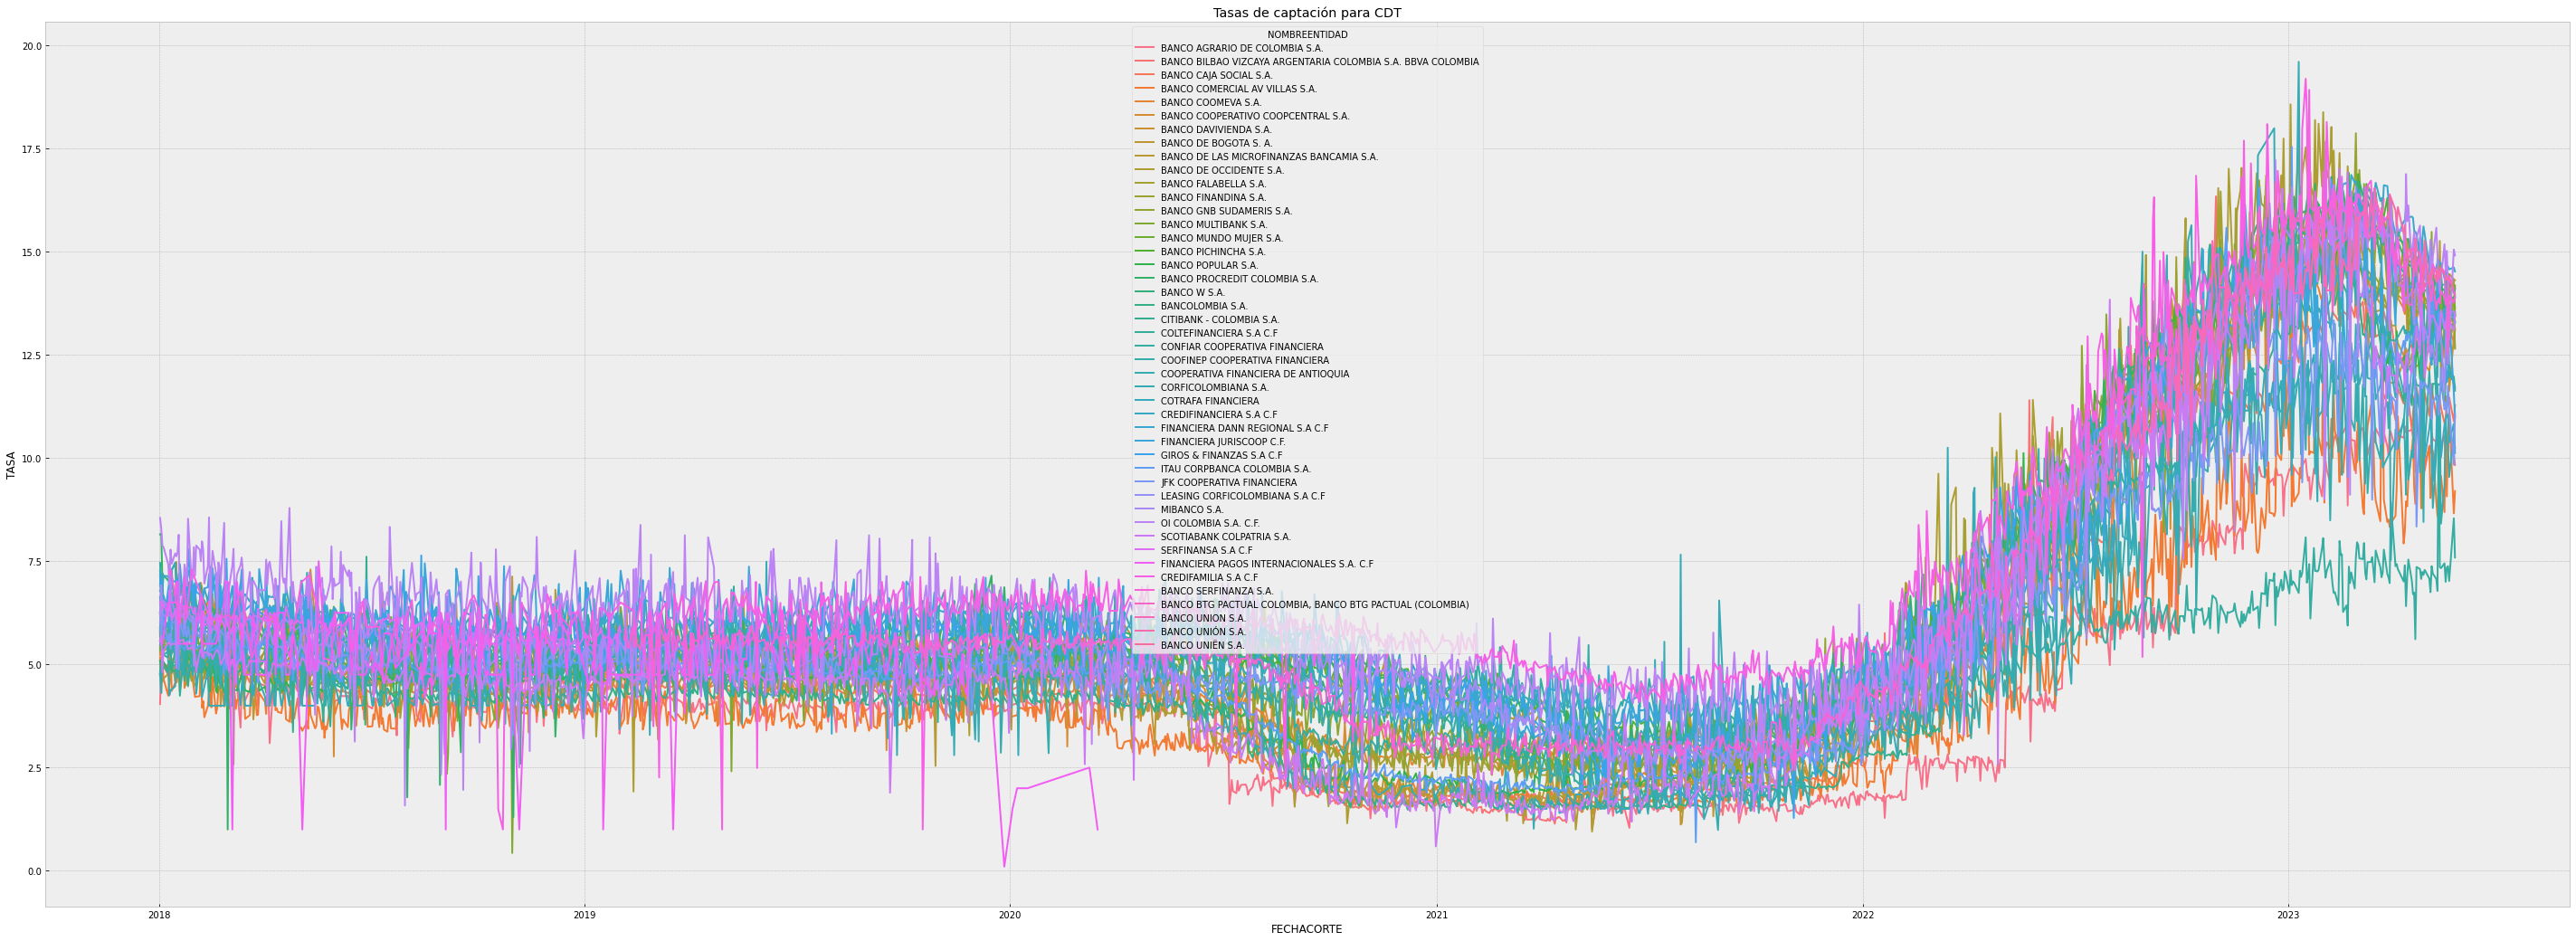

In [5]:
fig, ax = plt.subplots(1, 1, figsize =(50, 18))
sns.lineplot(x='FECHACORTE',y='TASA',hue='NOMBREENTIDAD',data=(stocks1.groupby(['FECHACORTE', 'NOMBREENTIDAD']).TASA.sum().to_frame()))
ax.set_title("Tasas de captación para CDT")

In [ ]:
import seaborn as sns


# Plot each year's time series in its own facet
g = sns.relplot(
    data=stocks1,
    x="month", y="passengers", col="year", hue="year",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=3, height=2, aspect=1.5, legend=False,
)

# Iterate over each subplot to customize further
for year, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8, .85, year, transform=ax.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    sns.lineplot(
        data=flights, x="month", y="passengers", units="year",
        estimator=None, color=".7", linewidth=1, ax=ax,
    )

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "Passengers")
g.tight_layout()

## Mirar por que cuando se aplica a monto 

Text(0.5, 1.0, 'Tasas de captación para CDT')

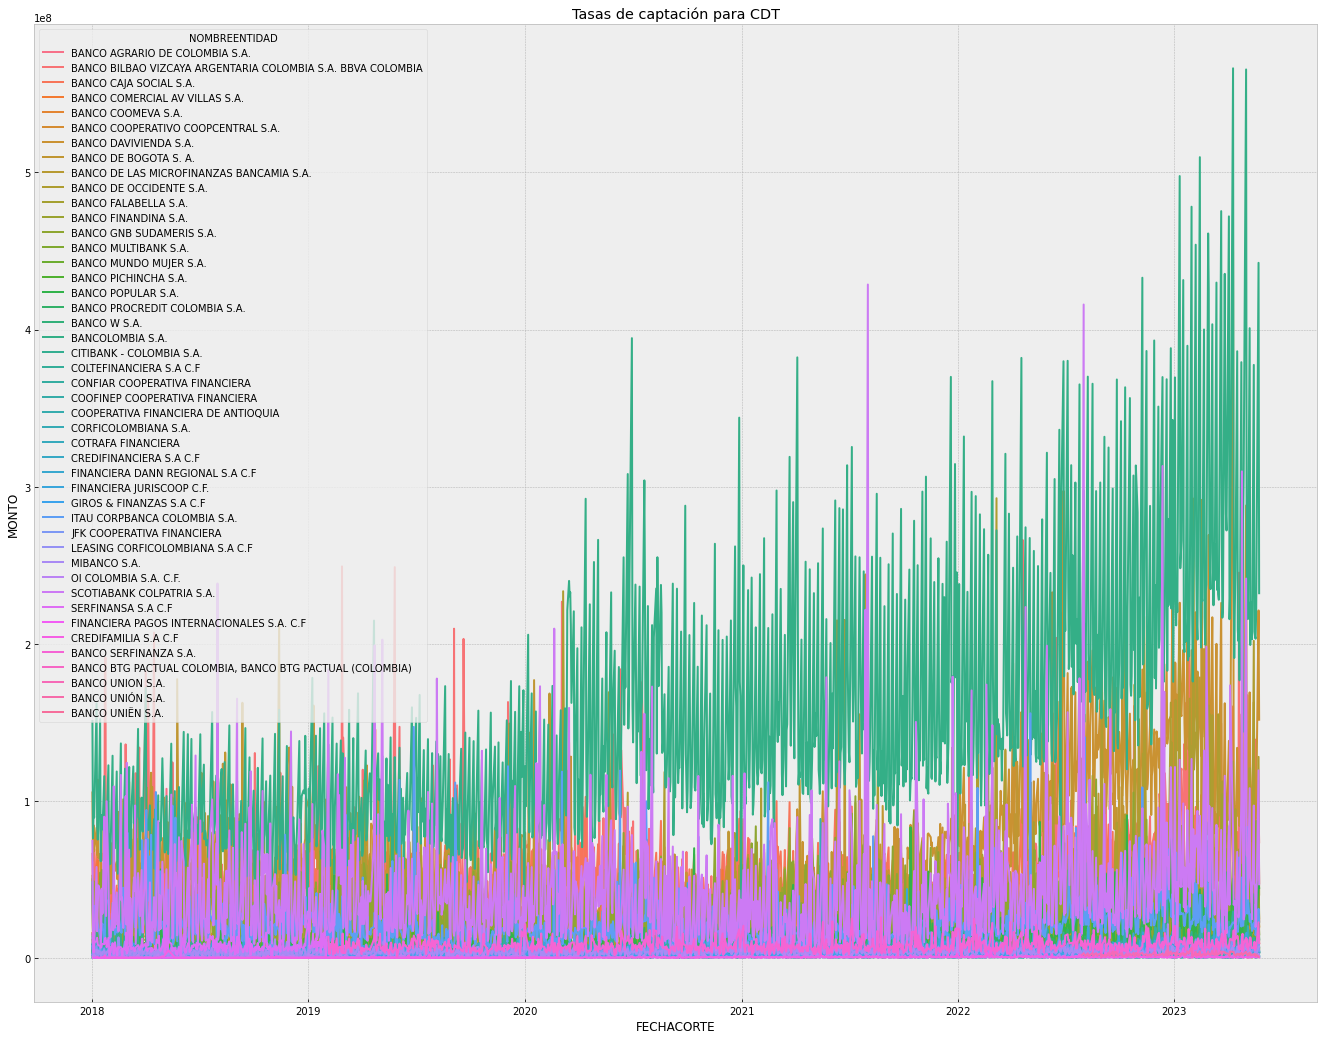

In [6]:
fig, ax = plt.subplots(1, 1, figsize= (23, 18))
sns.lineplot(x='FECHACORTE',y='MONTO',hue='NOMBREENTIDAD',data=(stocks1.groupby(['FECHACORTE', 'NOMBREENTIDAD']).MONTO.mean().to_frame()))
ax.set_title("Tasas de captación para CDT")

## Tasa de captación por tipo de entidad

Text(0.5, 1.0, 'Tasas de captación para CDT')

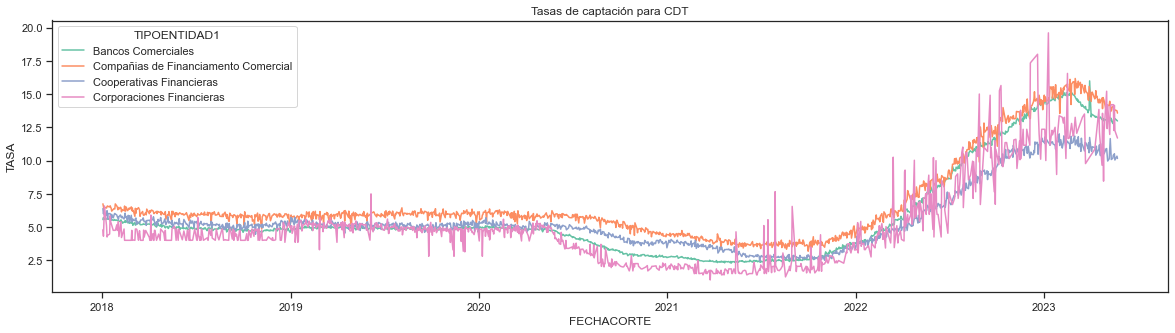

In [26]:
fig, ax = plt.subplots(1, 1, figsize= (20, 5))
categorias = {
    1: 'Bancos Comerciales',
    2: 'Corporaciones Financieras',
    4: 'Compañias de Financiamento Comercial',
    32: 'Cooperativas Financieras'
}

# Enmascarar los valores numéricos a categóricos
stocks1['TIPOENTIDAD1'] = stocks1['TIPOENTIDAD'].map(categorias)


sns.lineplot(x='FECHACORTE',y='TASA',hue='TIPOENTIDAD1',palette="Set2",data=(stocks1.groupby(['FECHACORTE', 'TIPOENTIDAD1']).TASA.mean().to_frame()))
ax.set_title("Tasas de captación para CDT")

## Kernels

Text(0.5, 1.0, 'Density plot for num_sold per country')

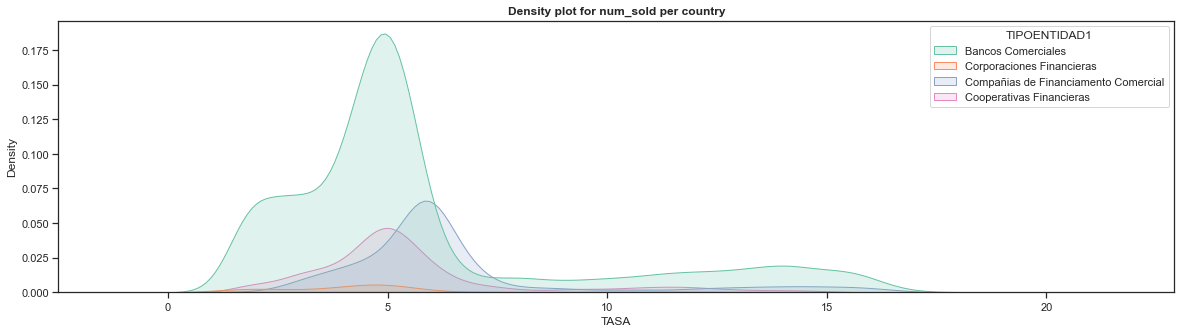

In [29]:
fig, ax = plt.subplots(1,1, figsize=(20, 5))

sns.kdeplot(data=stocks1, x='TASA', hue = 'TIPOENTIDAD1', palette="Set2",fill=True, alpha = 0.2, ax = ax)
ax.set_title('Density plot for num_sold per country', fontweight = 'bold')

Text(0.5, 1.0, 'Density plot for num_sold per country')

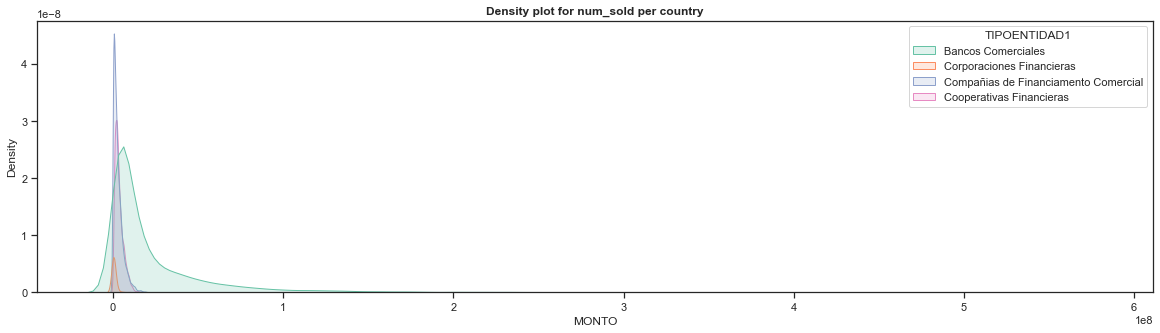

In [31]:
fig, ax = plt.subplots(1,1, figsize=(20, 5))

sns.kdeplot(data=stocks1, x='MONTO', hue = 'TIPOENTIDAD1', palette="Set2",fill=True, alpha = 0.2, ax = ax)
ax.set_title('Density plot for num_sold per country', fontweight = 'bold')

<AxesSubplot:xlabel='TASA', ylabel='NOMBREENTIDAD'>

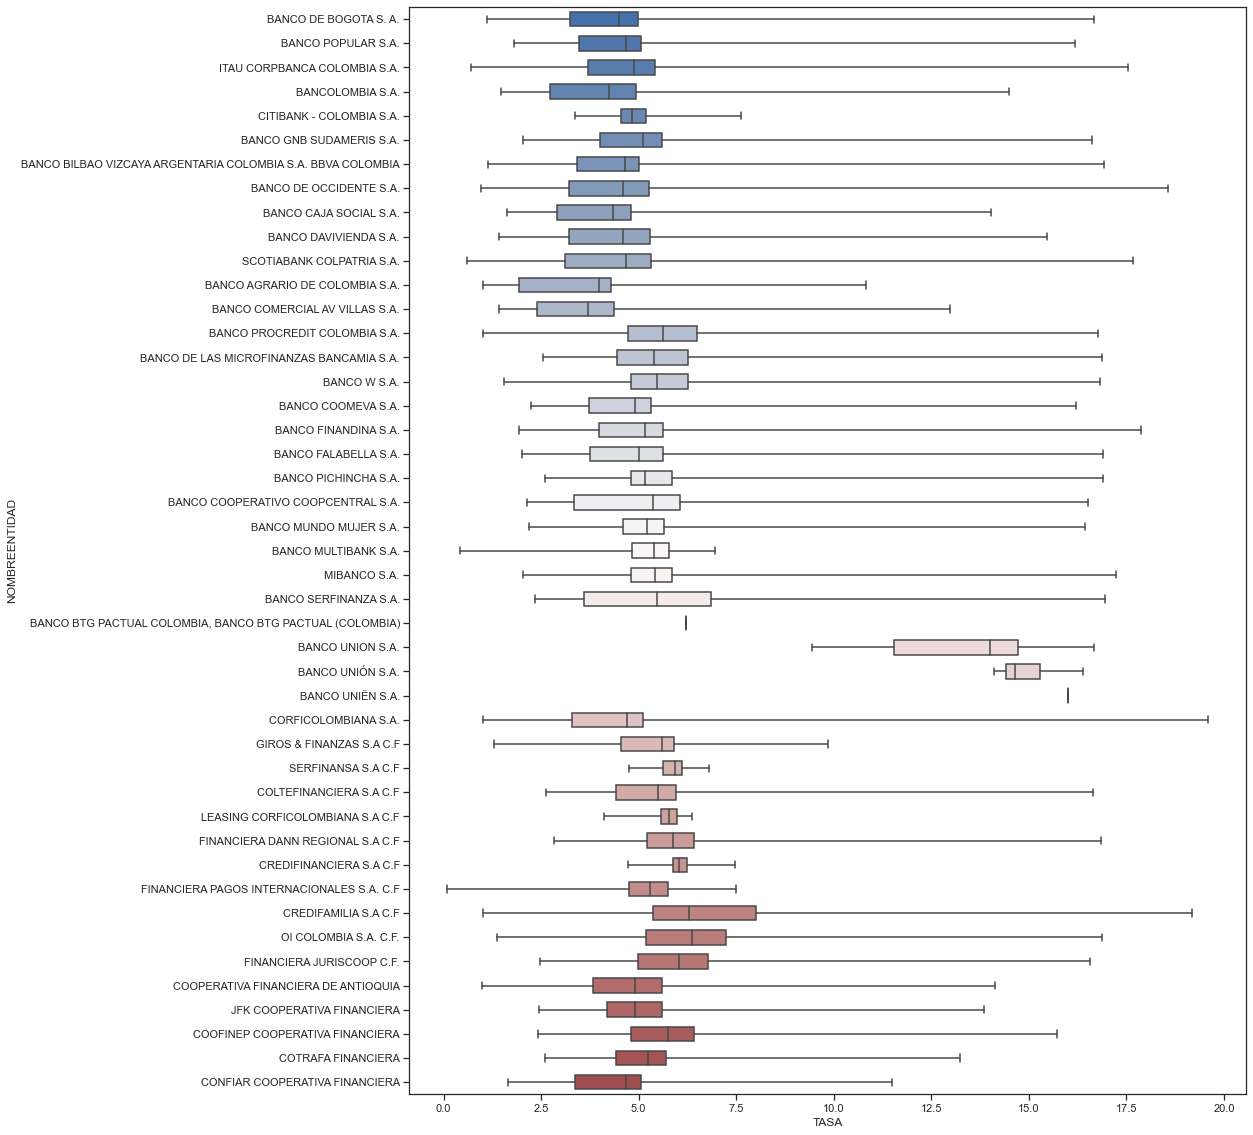

In [32]:
fig, ax = plt.subplots(1, 1, figsize = (15, 20))
sns.boxplot(x="TASA", y="NOMBREENTIDAD", data=stocks1,
            whis=[0, 100], width=.6, palette="vlag")

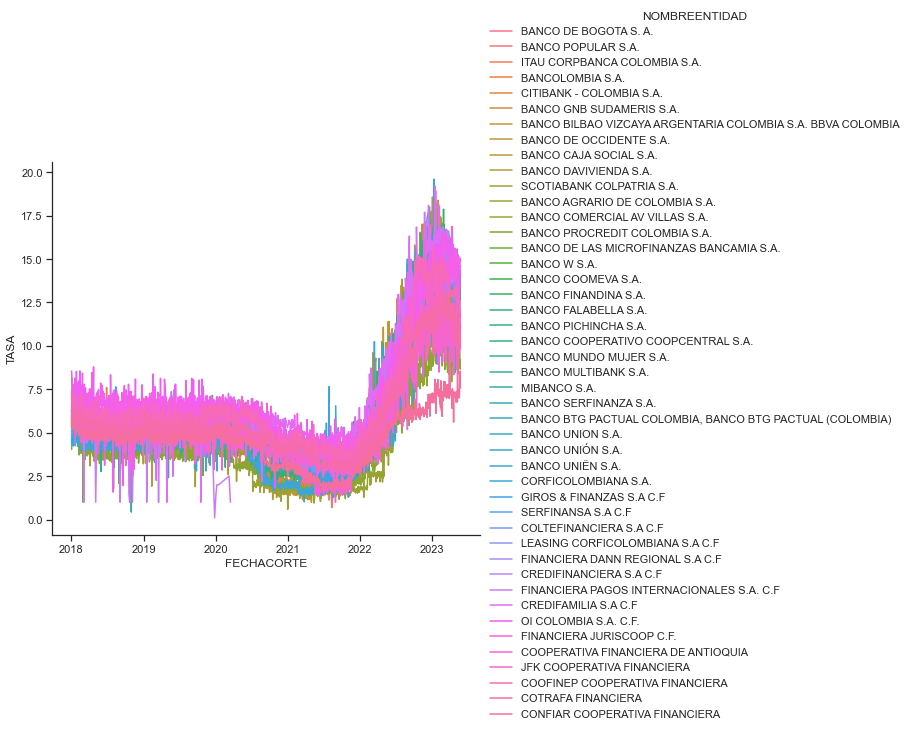

In [11]:
sns.set_theme(style="ticks")

# Define the palette as a list to specify exact values
palette = sns.color_palette("rocket_r")

# Plot the lines on two facets
sns.relplot(
    data=stocks1,
    x="FECHACORTE",
    y="TASA",
    hue="NOMBREENTIDAD",
    kind="line",
    height=6,
    aspect=1.25,
    facet_kws=dict(sharex=False)
)

,TIPOENTIDAD,CODIGOENTIDAD,NOMBREENTIDAD,FECHACORTE,TASA,MONTO


## Modelo

In [13]:
import copy
from pathlib import Path
import warnings
#!pip install pytorch_forecasting
#!pip install pytorch_lightning
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

import pytorch_forecasting 
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, encoders
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss, MultiLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [114]:
df = stocks1.groupby(['FECHACORTE', 'NOMBREENTIDAD']).TASA.mean().unstack()
df.iloc[:,:]

NOMBREENTIDAD,BANCO AGRARIO DE COLOMBIA S.A.,BANCO BILBAO VIZCAYA ARGENTARIA COLOMBIA S.A. BBVA COLOMBIA,"BANCO BTG PACTUAL COLOMBIA, BANCO BTG PACTUAL (COLOMBIA)",BANCO CAJA SOCIAL S.A.,BANCO COMERCIAL AV VILLAS S.A.,BANCO COOMEVA S.A.,BANCO COOPERATIVO COOPCENTRAL S.A.,BANCO DAVIVIENDA S.A.,BANCO DE BOGOTA S. A.,BANCO DE LAS MICROFINANZAS BANCAMIA S.A.,...,FINANCIERA JURISCOOP C.F.,FINANCIERA PAGOS INTERNACIONALES S.A. C.F,GIROS & FINANZAS S.A C.F,ITAU CORPBANCA COLOMBIA S.A.,JFK COOPERATIVA FINANCIERA,LEASING CORFICOLOMBIANA S.A C.F,MIBANCO S.A.,OI COLOMBIA S.A. C.F.,SCOTIABANK COLPATRIA S.A.,SERFINANSA S.A C.F
FECHACORTE,,,,,,,,,,,,,,,,,,,,,
2018-01-02,4.04,5.09,NaN,5.01,5.17,5.78,5.23,5.42,4.77,5.82,...,7.17,NaN,6.94,5.56,6.27,6.01,6.19,8.55,5.56,6.50
2018-01-03,5.03,4.99,NaN,5.00,4.31,5.19,6.72,5.26,4.82,6.23,...,6.35,5.5,7.01,5.46,5.57,6.34,6.92,8.30,5.71,6.52
2018-01-04,4.77,4.83,NaN,5.06,5.05,5.73,6.37,5.36,4.58,5.45,...,6.52,5.5,6.31,5.53,6.24,6.27,6.28,7.88,4.81,6.33
2018-01-05,4.98,5.03,NaN,4.91,4.65,5.76,6.44,5.50,4.66,5.84,...,6.16,NaN,5.98,5.67,5.97,6.17,6.55,7.84,5.33,6.47
2018-01-09,4.73,4.90,NaN,5.00,4.24,5.63,6.59,5.42,4.77,6.53,...,5.88,6.5,6.81,5.57,5.59,6.21,6.38,7.43,5.53,6.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-17,10.19,12.51,NaN,11.50,9.07,13.15,14.39,12.90,12.67,13.41,...,11.84,NaN,NaN,13.13,11.08,NaN,13.59,15.02,13.50,NaN
2023-05-18,10.18,14.41,NaN,11.27,10.59,13.45,13.90,12.82,13.15,13.15,...,12.07,NaN,NaN,13.05,11.75,NaN,13.67,14.16,12.28,NaN
2023-05-19,10.73,13.16,NaN,11.47,11.13,13.27,13.84,11.62,12.69,12.94,...,13.47,NaN,NaN,13.63,11.23,NaN,13.52,12.88,13.33,NaN


In [79]:
df['FECHACORTE'] = pd.to_datetime(df['FECHACORTE'])
df['MES'] = df.apply(lambda x: str(x.month))
#df["time_idx"] = (df["FECHA"].dt.year * 365) + (df["FECHA"].dt.month * 12) + (df["FECHA"].dt.day)
#df["time_idx"] -= df["time_idx"].min()
df['time_idx'] = [i for i in range(1300)]
print(df['time_idx'])
df.head()

AttributeError: 'Series' object has no attribute 'month'

In [80]:
freq = "1D"  # 1 day
sampling_interval = 24*60*60  # in seconds
sampling_frequency = 1.0 / sampling_interval  # sampling freq in Hz

In [86]:
df.columns

Index(['BANCO AGRARIO DE COLOMBIA S.A.',
       'BANCO BILBAO VIZCAYA ARGENTARIA COLOMBIA S.A. BBVA COLOMBIA',
       'BANCO BTG PACTUAL COLOMBIA, BANCO BTG PACTUAL (COLOMBIA)',
       'BANCO CAJA SOCIAL S.A.', 'BANCO COMERCIAL AV VILLAS S.A.',
       'BANCO COOMEVA S.A.', 'BANCO COOPERATIVO COOPCENTRAL S.A.',
       'BANCO DAVIVIENDA S.A.', 'BANCO DE BOGOTA S. A.',
       'BANCO DE LAS MICROFINANZAS BANCAMIA S.A.', 'BANCO DE OCCIDENTE S.A.',
       'BANCO FALABELLA S.A.', 'BANCO FINANDINA S.A.',
       'BANCO GNB SUDAMERIS S.A.', 'BANCO MULTIBANK S.A.',
       'BANCO MUNDO MUJER S.A.', 'BANCO PICHINCHA S.A.', 'BANCO POPULAR S.A.',
       'BANCO PROCREDIT COLOMBIA S.A.', 'BANCO SERFINANZA S.A.',
       'BANCO UNION S.A.', 'BANCO UNIËN S.A.', 'BANCO UNIÓN S.A.',
       'BANCO W S.A.', 'BANCOLOMBIA S.A.', 'CITIBANK - COLOMBIA S.A.',
       'COLTEFINANCIERA S.A C.F', 'CONFIAR COOPERATIVA FINANCIERA',
       'COOFINEP COOPERATIVA FINANCIERA',
       'COOPERATIVA FINANCIERA DE ANTIOQUIA', '

Text(0, 0.5, 'PSD [V**2/Hz]')

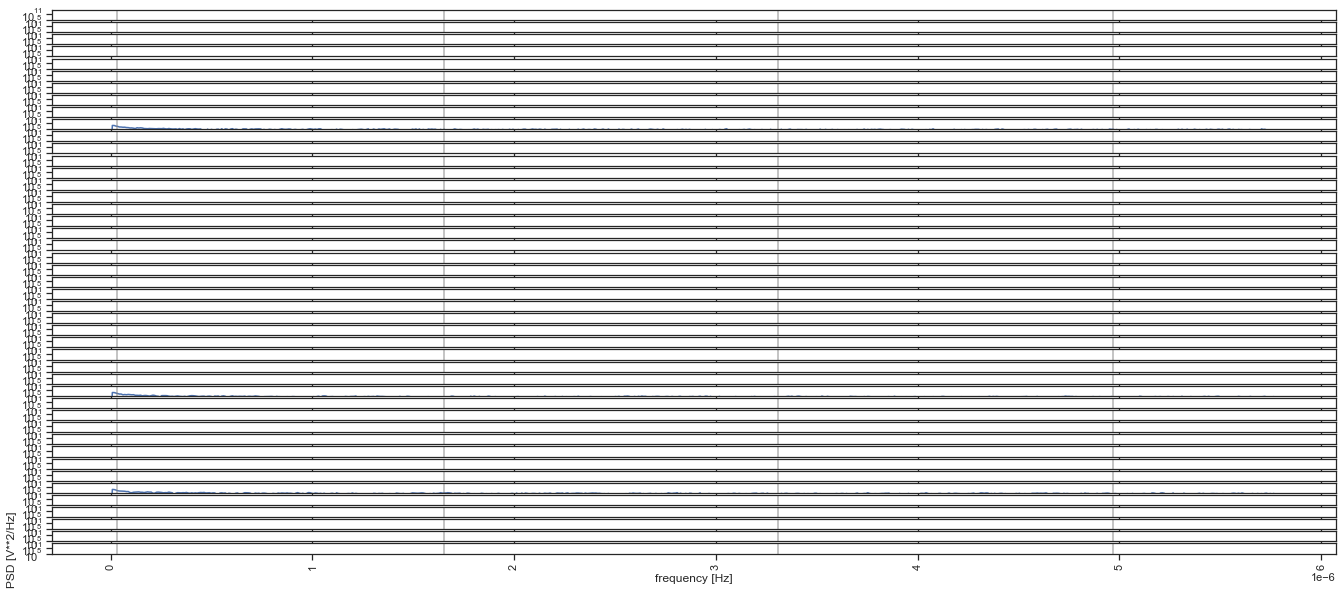

In [91]:
fig, axes = plt.subplots(df.shape[1], 1, figsize=(23,10), sharex=True)

for ax, product in zip(axes, df.columns):

    f, Pxx = signal.periodogram(df.loc[slice("2018","2023"),product], fs=sampling_frequency) 
    ax.semilogy(f, Pxx)
    ax.set_ylim([1e5, 1e15])
    
    for freq in [1.0/(sampling_interval*365), 1.0/(sampling_interval*7), 1.0/(sampling_interval*3.5), 1.0/(sampling_interval*2.33)]:
        ax.vlines(x=freq, color="gray", ymin=1e5, ymax=1e15, alpha=0.6)

plt.xticks(rotation=90)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')

In [92]:
# add calendar features
train_df_processed = add_cyclical_calendar_features(stocks1.set_index("FECHACORTE"), features=["weekday", "week"])
train_df_processed["weekend"] = (train_df_processed.index.dayofweek > 4).astype(int)
train_df_processed

NameError: name 'add_cyclical_calendar_features' is not defined

In [71]:
max_prediction_length = 10
max_encoder_length = 10
training_cutoff = df["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    df[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="TASA",
    group_ids=["MES"],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=['BANCO DE BOGOTA ', 'BANCO POPULAR ',
       'ITAU CORPBANCA COLOMBIA ', 'BANCO GNB SUDAMERIS ',
       'BANCO BBVA', 'BANCO DE OCCIDENTE ', 'BANCO CAJA SOCIAL ',
       'BANCO DAVIVIENDA ', 'SCOTIABANK COLPATRIA ',
       'BANCO AGRARIO DE COLOMBIA ', 'BANCO COMERCIAL AV VILLAS ',
       'BANCO DE LAS MICROFINANZAS BANCAMIA ', 'BANCO W ', 'BANCO COOMEVA ',
       'BANCO FINANDINA ', 'BANCO FALABELLA ', 'BANCO PICHINCHA ',
       'BANCO COOPERATIVO COOPCENTRAL ', 'BANCO MUNDO MUJER ', 'MIBANCO ',
       'COLTEFINANCIERA  ', 'FINANCIERA DANN REGIONAL  ', 'OI COLOMBIA ',
       'FINANCIERA JURISCOOP', 'COOPERATIVA FINANCIERA DE ANTIOQUIA',
       'JFK COOPERATIVA FINANCIERA', 'COOFINEP COOPERATIVA FINANCIERA',
       'COTRAFA FINANCIERA', 'CONFIAR COOPERATIVA FINANCIERA'],
    time_varying_unknown_reals=['TASA'],
    target_normalizer=GroupNormalizer(
        groups=['MES'], transformation="softplus"
    ),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
    categorical_encoders={
        'S100': pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
        'I100':pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
        'C100':pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
        'C101':pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True)
    }
)

validation = TimeSeriesDataSet.from_dataset(training, df, predict=True, stop_randomization=True)

batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=8)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=8)

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()

trainer = pl.Trainer(
    max_epochs=50, 
    gradient_clip_val=0.1,
    limit_train_batches=20,
    log_every_n_steps=10,
    callbacks=[lr_logger, early_stop_callback],
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=4
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

compiled_model = torch.compile(tft)
trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)

KeyError: 'FECHACORTE'

In [18]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

best_model_path

NameError: name 'trainer' is not defined

In [19]:
val_prediction_results = best_tft.predict(val_dataloader, mode="raw", return_x=True)

NameError: name 'best_tft' is not defined

NameError: name 'best_tft' is not defined

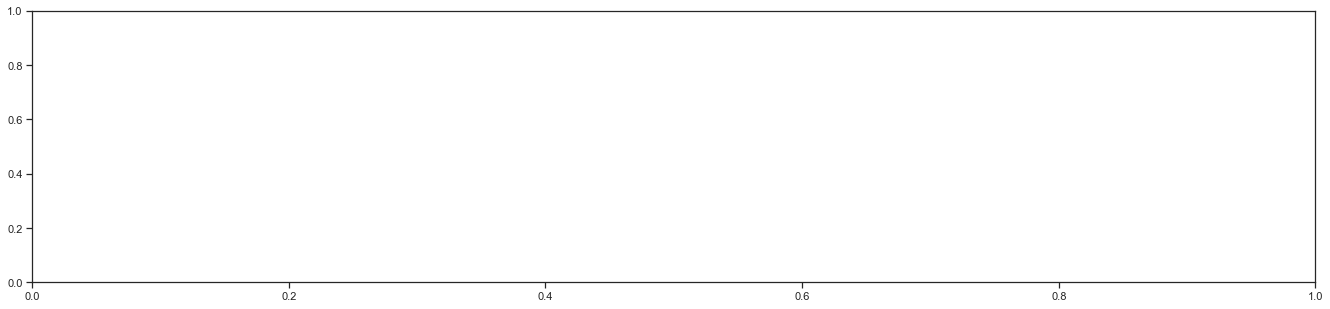

In [20]:
import matplotlib.pyplot as plt

for idx in range(1):
    fig, ax = plt.subplots(figsize=(23,5))
    best_tft.plot_prediction(val_prediction_results.x, # network input
                            val_prediction_results.output, # network output
                            idx=idx,
                            add_loss_to_title=True,
                            ax=ax);

In [21]:
study = optimize_hyperparameters(
     train_dataloader,
     val_dataloader,
     model_path="optuna_test",
     n_trials=2,
     max_epochs=50,
     loss=QuantileLoss(),
     gradient_clip_val_range=(0.01, 1.0),
     hidden_size_range=(8, 128),
     hidden_continuous_size_range=(8, 128),
     attention_head_size_range=(1, 4),
     learning_rate_range=(0.001, 0.1),
     dropout_range=(0.1, 0.3),
     trainer_kwargs=dict(limit_train_batches=30),
     reduce_on_plateau_patience=4,
     use_learning_rate_finder=True,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# # pickle study results
with open("study.pkl", "wb") as fout:
     pickle.dump(study, fout)

# # show best hyperparameters
study.best_trial.params

NameError: name 'train_dataloader' is not defined

In [22]:
val_prediction_results = best_tft.predict(
    val_dataloader, 
    mode="prediction", # get only median predictions
    return_x=True,
    )
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(val_prediction_results.x, val_prediction_results.output)
features = list(set(predictions_vs_actuals['support'].keys())-set(['num_sold_lagged_by_365', 'num_sold_lagged_by_7']))
for feature in features:
    best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals, name=feature);

NameError: name 'best_tft' is not defined